### Imports and Settings

In [1]:
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorly as tl
import gc
import pyprep

%matplotlib inline

### Load data

Specify responder/ non-responder status

In [26]:
# Change this manually
responder_status = 'Bart'  # Styrofoam head model
#responder_status = 'Non-Responder'
#responder_status = 'Responder'

Specify directory for all subject data, and the target, patient_id, and day for one subject

In [ ]:
# For loading Bart's test recording data
patient_folder = '/Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart'
treatment_path = '/Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/bart_dlpfc_t47_treatment_20231117_050322.mff'
target = 'dlpfc'
patient_id = 'bart'
day = 'day1'

In [3]:
mne_path = f'{patient_folder}/mne/{day}/'
print(f'Preprocessed data will be saved to: {mne_path}')
ERP_path = mne_path + 'ERP/'
AR_path = mne_path + 'autoreject/'
tucker_decomp_path = mne_path + 'tucker_decomp/'

# Create new directory for edited files
if not os.path.exists(mne_path):
    os.makedirs(mne_path)
    print(f'Writing new directory {mne_path}')

# Create new directory for saving ERP plots
if not os.path.exists(ERP_path):
    os.makedirs(ERP_path)
    print(f'Writing new directory {ERP_path}')

# Create new directory for saving autoreject plots
if not os.path.exists(AR_path):
    os.makedirs(AR_path)
    print(f'Writing new directory {AR_path}')

# Directory for saving tucker decomp core diagonal tensor plot
if not os.path.exists(tucker_decomp_path):
    os.makedirs(tucker_decomp_path)
    print(f'Writing new directory {tucker_decomp_path}')

Preprocessed data will be saved to: /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/


In [4]:
from mffpy import XML

# EEG recording gains and impedance values can be extracted from info1.xml in the mff package in the "calibrations"
xml_contents = XML.from_file(treatment_path + "/info1.xml")
#print(dir(xml_contents))
calibrations_data = xml_contents.calibrations

# Impedance values by channel are under ICAL
ch_impedances = (calibrations_data['ICAL']['channels'])
print(ch_impedances)

2024-08-26 10:44:28,605 - XMLType - INFO - type <class 'mffpy.xml_files.XML'> cannot be registered


{1: 12.742005, 2: 13.387213, 3: 13.145471, 4: 18.64004, 5: 14.701919, 6: 14.26465, 7: 16.008932, 8: 15.1522045, 9: 15.884698, 10: 12.782191, 11: 12.524368, 12: 14.387425, 13: 13.948999, 14: 14.076405, 15: 14.20574, 16: 15.741261, 17: 15.006815, 18: 14.005265, 19: 13.39832, 20: 13.984023, 21: 16.48125, 22: 13.777711, 23: 16.071766, 24: 14.657253, 25: 14.510931, 26: 17.129158, 27: 13.990322, 28: 13.759285, 29: 13.639709, 30: 14.112424, 31: 22.744654, 32: 14.114501, 33: 13.33031, 34: 14.421339, 35: 13.533578, 36: 12.866729, 37: 13.889957, 38: 13.534503, 39: 13.999064, 40: 12.656768, 41: 13.66068, 42: 14.675455, 43: 16.112883, 44: 17.812346, 45: 16.307417, 46: 12.455923, 47: 12.666348, 48: 13.245736, 49: 13.415278, 50: 14.980044, 51: 16.152678, 52: 16.162909, 53: 15.980411, 54: 14.223077, 55: 13.411673, 56: 13.114514, 57: 13.014136, 58: 14.332998, 59: 23.089401, 60: 17.177223, 61: 13.228292, 62: 12.63051, 63: 13.01195, 64: 14.042221, 65: 17.538473, 66: 17.985966, 67: 302.93317, 68: 55.3164

In [5]:
# Create list of bad channels based on impedance values over 100 kOhms
ch_bads_list = []

for ch, impedance in ch_impedances.items():
    if impedance > 100:
        ch = 'E' + str(ch)
        ch_bads_list.append(ch)
        
ch_bads_list.append('VREF')        
print(f'Number of channels with impedance value > 100 kOhms: {len(ch_bads_list)}')

Number of channels with impedance value > 100 kOhms: 8


In [6]:
# Load raw treatment file and update bads list to include high impedance channels + VREF
raw = mne.io.read_raw_egi(treatment_path, preload='True')
raw.info['bads'] = ch_bads_list
print(f'\nBad channels: {raw.info['bads']}')

Reading EGI MFF Header from /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/bart_dlpfc_t47_treatment_20231117_050322.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
Reading 0 ... 690448  =      0.000 ...   690.448 secs...

Bad channels: ['E67', 'E73', 'E82', 'E216', 'E231', 'E252', 'E255', 'VREF']


In [7]:
# Crop a copy of the raw to the first and last 30 sec of the treatment recording
# These timepoints should be resting state, so can be used for bad channel rejection

raw_time = len(raw)/1000  # Convert time from samples to seconds
print(f'Raw recording length (s): {raw_time}')
last_30 = raw_time - 30

raw_first_30 = raw.copy().crop(tmin=0, tmax=30).load_data()
raw_last_30 = raw.copy().crop(tmin=last_30, tmax=(raw_time - 0.01)).load_data()

# Visualize raw resting state portions of recording (before applying an average reference)
#raw_first_30.plot(title='Raw recording first 30 seconds')
#raw_last_30.plot(title='Raw recording last 30 seconds')

Raw recording length (s): 690.449


### Bad channel rejection

Run bad channel rejection for the first and last 30 seconds of the treatment recording, then merge bads list

In [8]:
from pyprep.find_noisy_channels import NoisyChannels

nc = NoisyChannels(raw_first_30.copy(), random_state=42)
nc.find_all_bads(channel_wise=False)
bad_channels = nc.bad_by_deviation + nc.bad_by_hf_noise + nc.bad_by_dropout + nc.bad_by_ransac + nc.bad_by_correlation

# Print bad channel info
print('  Removed '+str(len(bad_channels))+' total:')
print('  --> Removed '+str(len(nc.bad_by_deviation))+' channels found to be bad by deviation.')
print('  --> Removed '+str(len(nc.bad_by_hf_noise))+' channels found to be bad by high frequency noise.')
print('  --> Removed '+str(len(nc.bad_by_correlation))+' channels found to be bad by correlations.')
print('  --> Removed '+str(len(nc.bad_by_dropout))+' channels found to be bad by dropout.')
print('  --> Removed '+str(len(nc.bad_by_ransac))+' channels found to be bad by RANSAC.')

# Add noisy channels to bad channels list
ch_bads_list.extend(bad_channels)

# Removed 14 channels 
# Bad by high freq noise, corrleations, and RANSAC

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...
Progress: 30%... 50%... 60%... 80%... 100%

RANSAC done!
  Removed 126 total:
  --> Removed 0 channels found to be bad by deviation.
  --> Removed 0 channels found to be bad by high frequency noise.
  --> Removed 120 channels found to be bad by correlations.
  --> Removed 0 channels found to be bad by dropout.
  --> Removed 6 channels found to be bad by RANSAC.


In [9]:
print(ch_bads_list)
print(len(ch_bads_list))

['E67', 'E73', 'E82', 'E216', 'E231', 'E252', 'E255', 'VREF', 'E66', 'E77', 'E181', 'E194', 'E195', 'E211', 'E7', 'E9', 'E11', 'E13', 'E19', 'E21', 'E22', 'E25', 'E28', 'E30', 'E38', 'E39', 'E42', 'E44', 'E45', 'E51', 'E52', 'E53', 'E58', 'E59', 'E60', 'E63', 'E68', 'E69', 'E78', 'E80', 'E81', 'E83', 'E86', 'E87', 'E88', 'E89', 'E90', 'E93', 'E96', 'E97', 'E98', 'E99', 'E101', 'E102', 'E104', 'E105', 'E106', 'E107', 'E108', 'E109', 'E110', 'E117', 'E118', 'E119', 'E120', 'E121', 'E124', 'E125', 'E126', 'E127', 'E128', 'E129', 'E130', 'E131', 'E132', 'E135', 'E136', 'E137', 'E139', 'E140', 'E141', 'E142', 'E143', 'E144', 'E145', 'E146', 'E149', 'E150', 'E152', 'E153', 'E154', 'E155', 'E158', 'E159', 'E160', 'E161', 'E162', 'E163', 'E164', 'E167', 'E168', 'E171', 'E172', 'E174', 'E177', 'E178', 'E179', 'E180', 'E182', 'E183', 'E184', 'E185', 'E186', 'E192', 'E193', 'E196', 'E197', 'E198', 'E201', 'E207', 'E208', 'E209', 'E213', 'E217', 'E219', 'E224', 'E225', 'E227', 'E233', 'E240', 'E24

In [10]:
# Merge the ch_bads_list and raw.info['bads'] and remove duplicates
raw.info['bads'] = list(set(raw.info['bads']) | set(ch_bads_list))

print(f'Bad channels: {raw.info['bads']}')
print(f'\nNumber of bad channels: {len(raw.info['bads'])}')
print(f'\nData shape before interpolation: {raw._data.shape}')

Bad channels: ['E136', 'E22', 'E224', 'E146', 'E252', 'E255', 'E121', 'E192', 'E25', 'E45', 'E193', 'E198', 'E82', 'E107', 'E194', 'E101', 'E217', 'E196', 'E130', 'E167', 'E87', 'E125', 'E163', 'VREF', 'E227', 'E171', 'E131', 'E144', 'E197', 'E78', 'E250', 'E155', 'E96', 'E58', 'E104', 'E19', 'E179', 'E186', 'E256', 'E185', 'E153', 'E150', 'E9', 'E98', 'E162', 'E161', 'E251', 'E59', 'E83', 'E93', 'E109', 'E172', 'E73', 'E182', 'E126', 'E141', 'E180', 'E231', 'E88', 'E183', 'E11', 'E137', 'E68', 'E110', 'E39', 'E81', 'E225', 'E174', 'E66', 'E117', 'E181', 'E28', 'E184', 'E178', 'E38', 'E97', 'E240', 'E219', 'E211', 'E13', 'E159', 'E77', 'E140', 'E195', 'E67', 'E233', 'E7', 'E30', 'E124', 'E216', 'E90', 'E135', 'E158', 'E213', 'E160', 'E105', 'E241', 'E44', 'E120', 'E69', 'E207', 'E127', 'E52', 'E152', 'E108', 'E143', 'E129', 'E209', 'E128', 'E42', 'E208', 'E51', 'E80', 'E21', 'E118', 'E149', 'E53', 'E201', 'E89', 'E63', 'E154', 'E99', 'E168', 'E102', 'E119', 'E164', 'E86', 'E177', 'E132

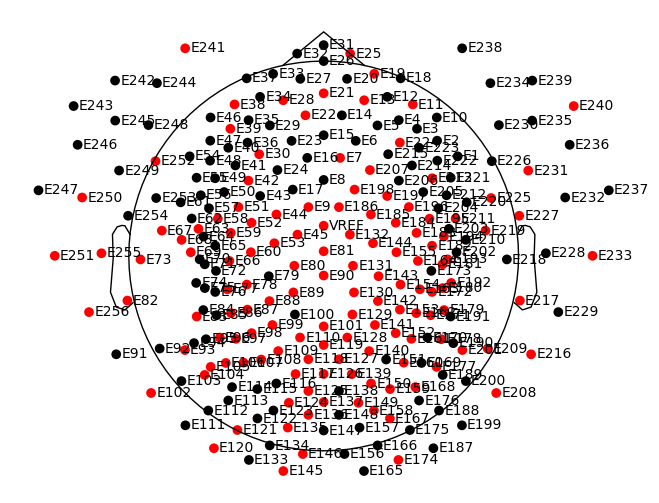

In [11]:
# Red points are bad channels
raw.plot_sensors(show_names=True); 

In [12]:
# Do bad channel rejection on raw.copy and apply bad channels to original raw by inputting them into bad channels list
# then interpolate bad channels
raw = raw.interpolate_bads(reset_bads=True) # This will clear out data.info['bads']
print("Data shape post interpolation:", raw._data.shape)

Interpolating bad channels
    Automatic origin fit: head of radius 96.5 mm
Computing interpolation matrix from 123 sensor positions
Interpolating 134 sensors
Data shape post interpolation: (259, 690449)


In [13]:
raw.info

<Info | 11 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 257 EEG, 2 Stimulus
 custom_ref_applied: True
 device_info: 1 item (dict)
 dig: 260 items (3 Cardinal, 257 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-11-04 17:58:27 UTC
 nchan: 259
 projs: []
 sfreq: 1000.0 Hz
 utc_offset: -0400
>

### Apply average reference, create epochs, explore data

In [14]:
# Set average reference and save as a projector
# It is best to remove bad channels prior to computing a projector
# Saving the reference as a projector allows flexibility, as the reference can be recomputed in later steps to ensure it is still zero-mean
raw = raw.set_eeg_reference(ref_channels='average', projection=True)
raw.apply_proj()

# Save raw with bad channel rejection and average ref applied
raw.save(f'{mne_path}{patient_id}_{day}_nobads_raw.fif',overwrite=True)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/bart_day1_nobads_raw.fif


/var/folders/bf/tx13kltn043fzjw05wb4ck0w0000gn/T/ipykernel_2664/2944182310.py:8: RuntimeWarning: Acquisition skips detected but did not fit evenly into output buffer_size, will be written as zeroes.
  raw.save(f'{mne_path}{patient_id}_{day}_nobads_raw.fif',overwrite=True)


Closing /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/bart_day1_nobads_raw.fif
[done]


In [15]:
#  Create and save epochs
# Read DIN1 events to create epochs based on stim triggers
# Baseline correction is automatic for tmin to t=0 (unless baseline is specified)
events = mne.find_events(raw, stim_channel = 'DIN1')
epochs = mne.Epochs(raw, events, tmin=-0.08, tmax=0.12, preload=True)
epochs.events.shape[0]
# 600 epochs created for Event ID '1

# Save epochs to file
print(f'Saving raw epoch files to: {mne_path}')
epochs.save(f'{mne_path}{patient_id}_{day}_nobads_epo.fif',overwrite=True)

600 events found
Event IDs: [1]
Not setting metadata
600 matching events found
Setting baseline interval to [-0.08, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 600 events and 201 original time points ...
0 bad epochs dropped
Saving raw epoch files to: /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/
Overwriting existing file.


In [16]:
print(f'Epochs shape: {epochs._data.shape}')

Epochs shape: (600, 259, 201)


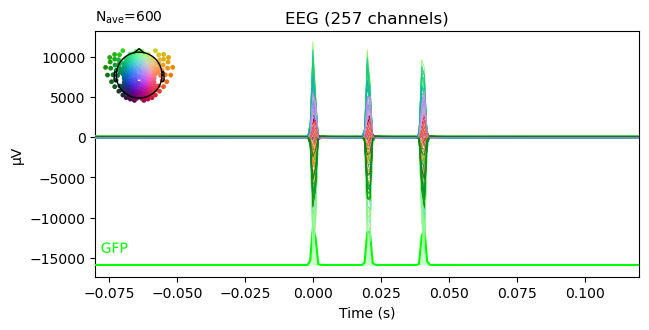

Saving raw TEP image file to: /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/ERP/


In [17]:
# Plot raw TEP (just to explore data)
# Create average evoked
avg_evoked = epochs.copy().average()

# Plot whole brain average evoked activity (microvolts)
fig = avg_evoked.plot(gfp=True)

# Save raw TEP plot
print(f'Saving raw TEP image file to: {ERP_path}')
fig.savefig(f'{ERP_path}/{patient_id}_{day}_TEP_raw.png')

Saving ERP image files to: /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/ERP/
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


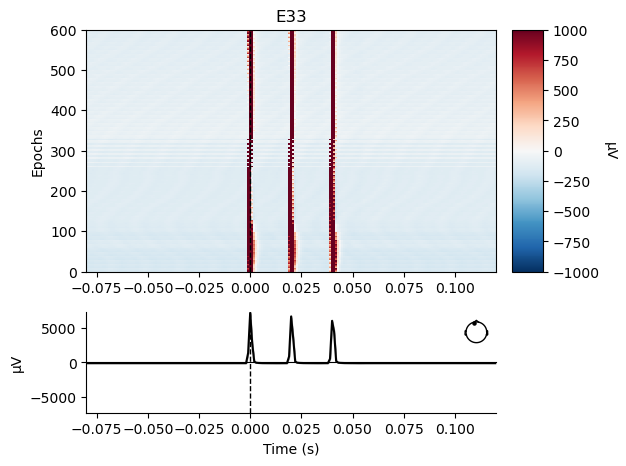

Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


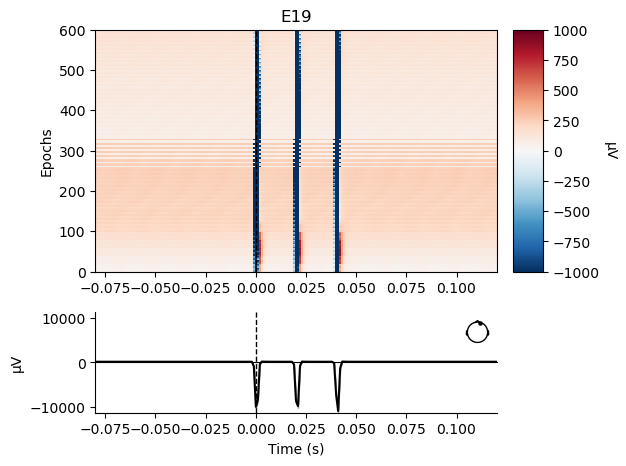

Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


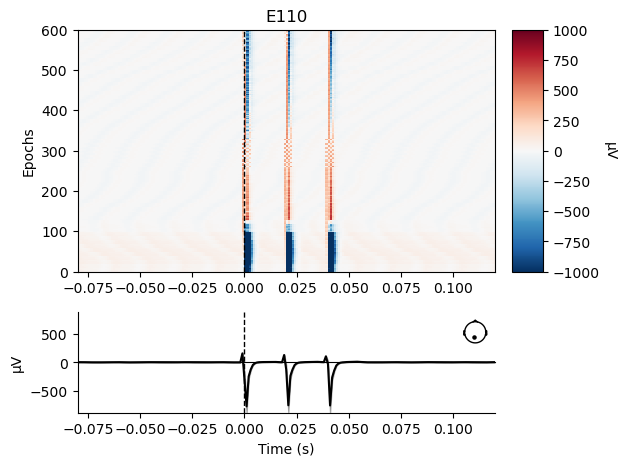

In [18]:
# Plot raw ERP for channels E33, E19, and E110
print(f'Saving ERP image files to: {ERP_path}')

# Plot channel over epochs pre artifact removal
# Channel E33 (left dlpfc)
fig = epochs.plot_image(picks=['E33'], vmin=-1000, vmax=1000)
fig[0].axes[1].set_ylim([-10000,10000])
fig[0]
fig[0].savefig(f'{ERP_path}/{patient_id}_{day}_E33_raw.png')

# Channel E19 (right dlpfc)
fig = epochs.plot_image(picks=['E19'], vmin=-1000, vmax=1000)
fig[0].axes[1].set_ylim([-5000,5000])
fig[0] 
fig[0].savefig(f'{ERP_path}/{patient_id}_{day}_E19_raw.png')

# Channel E110 (left parietal)
fig = epochs.plot_image(picks=['E110'], vmin=-1000, vmax=1000)
fig[0].axes[1].set_ylim([-5000,5000])
fig[0] ;
fig[0].savefig(f'{ERP_path}/{patient_id}_{day}_E110_raw.png')

### Tucker decomposition

/Users/Bella/mambaforge/envs/clean/lib/python3.12/site-packages/tensorly/tucker_tensor.py:425: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
<EpochsArray |  600 events (all good), -0.08 - 0.12 sec, baseline -0.08 – 0 sec, ~238.6 MB, data loaded,
 '1': 600>
Saving post-tucker decomposition day1 epochs file to /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/
Saving Diagonal Core Tensor Values image file to: /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/tucker_decomp/
32.459312200546265


21866

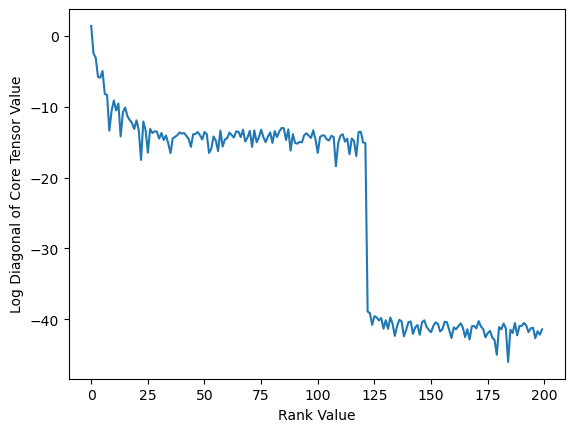

In [19]:
%matplotlib inline
import tensorly as tl
from tensorly.decomposition import tucker
import time
tic = time.time()

# Change these values as necessary
rank = 200
components_to_remove = 32

# Plot tensor equivalent of singular values (diagonal of core tensor)
def get_3dtensor_diag(tensor):
    diag = []
    for i in range(tensor.shape[0]):
        diag.append(tensor[i,i,i])
    return np.array(diag)

# Define data and stim channels
epoch_data = epochs.copy().get_data()[:,0:257,:]
epoch_stim = epochs.copy().get_data()[:,257:,:]

# Run tucker decomposition
tucker_decomp = tucker(epoch_data, rank)

# Get the core tensor diagonal values
tucker_diag = get_3dtensor_diag(tucker_decomp.core)
diagonal_core_tensor = np.abs(tucker_diag)
log_diagonal_core_tensor = np.log(np.abs(tucker_diag))

# Plot values of core tensor diagonal (log scale)
diag_indices = np.arange(len(log_diagonal_core_tensor))
plt.plot(diag_indices, log_diagonal_core_tensor)
plt.xlabel('Rank Value')
plt.ylabel('Log Diagonal of Core Tensor Value')

# Zero out first n components to try and remove artifact
tucker_decomp.factors[2][:,0:components_to_remove] = 0.0

# Convert numpy array back into an epochs array
tensor_cleaned = tl.tucker_to_tensor(tucker_decomp)
tensor_cleaned = np.concatenate((tensor_cleaned, epoch_stim),axis=1)
epochs_tucker = mne.EpochsArray(tensor_cleaned, epochs.info, events=events, tmin=-0.08, baseline=(-0.08, 0))
print(epochs_tucker)

# Save cleaned epochs and raw to file
print(f'Saving post-tucker decomposition {day} epochs file to {mne_path}')
epochs_tucker.save(f'{mne_path}{patient_id}_{day}_tucker{rank}_{components_to_remove}_epo.fif',overwrite=True)

del tucker_decomp, epoch_data, epoch_stim, tucker_diag, diagonal_core_tensor, log_diagonal_core_tensor, diag_indices

# Save core tensor diagonal vales plot
print(f'Saving Diagonal Core Tensor Values image file to: {tucker_decomp_path}')
plt.savefig(f'{tucker_decomp_path}/diag_core_tensor_{patient_id}_rank{rank}.png')

print(time.time()-tic)
gc.collect()

Saving ERP image files to: /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/ERP/
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


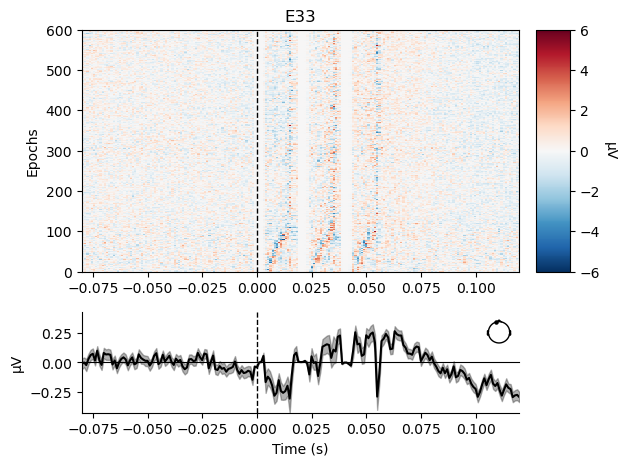

Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


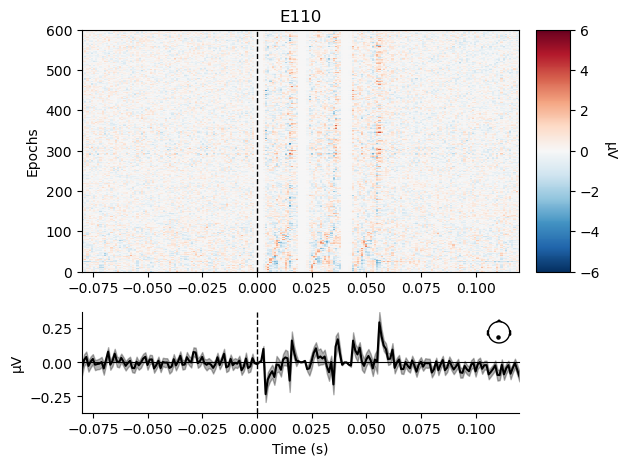

Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


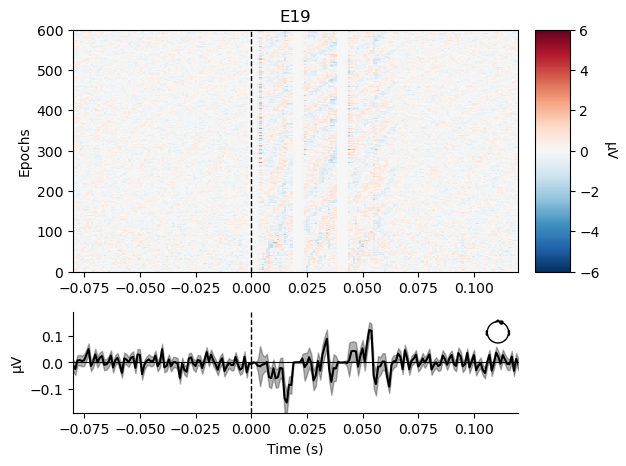

In [20]:
# Plot channel over epochs post tucker decomposition artifact removal
print(f'Saving ERP image files to: {ERP_path}')

# Channel E33
fig = epochs_tucker.plot_image(picks=['E33'], vmin= -6, vmax= 6)
fig[0].axes[1].set_ylim([-3,3])
fig[0]
fig[0].savefig(f'{ERP_path}{patient_id}_{day}_E33_tucker{rank}_{components_to_remove}.png')

# Channel E110
fig = epochs_tucker.plot_image(picks=['E110'], vmin= -6, vmax= 6)
fig[0].axes[1].set_ylim([-3,3])
fig[0]
fig[0].savefig(f'{ERP_path}{patient_id}_{day}_E110_tucker{rank}_{components_to_remove}.png')

# Channel E19
fig = epochs_tucker.plot_image(picks=['E19'], vmin= -6, vmax= 6)
fig[0].axes[1].set_ylim([-3,3])
fig[0]
fig[0].savefig(f'{ERP_path}{patient_id}_{day}_E19_tucker{rank}_{components_to_remove}.png')

#### Reject bad segments

Use autoreject library to reject bad segments. Note this may take some time/memory with longer data sets.

In [21]:
from autoreject import AutoReject, Ransac


def autoreject_bad_segments(epochs, method='autoreject'):
    # Use mne-compatible autoreject library to clean epoched data
    n_interpolates = np.array([1, 4, 32])
    consensus_percs = np.linspace(0, 1.0, 11)

    if method=='autoreject':
        ar = AutoReject(n_interpolates, consensus_percs, thresh_method='bayesian_optimization', random_state=42)
    elif method=='ransac':
        ar = Ransac()
    else:
        raise pipeline_log.ValueError("Specified bad segment method not implemented. Current options are 'autoreject' and 'ransac'.")
    epochs = ar.fit_transform(epochs)
    return epochs, ar


epochs_autoreject, ar = autoreject_bad_segments(epochs_tucker, method='autoreject')

# Droppped the majority of the first 6 trains

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/257 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/257 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/600 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/600 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/600 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/600 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=32


  0%|          | Repairing epochs : 0/600 [00:00<?,       ?it/s]

Dropped 54 epochs: 7, 10, 11, 14, 20, 21, 22, 29, 30, 32, 33, 40, 41, 58, 59, 60, 62, 69, 70, 71, 72, 73, 77, 78, 79, 80, 81, 87, 88, 89, 90, 92, 93, 110, 129, 137, 138, 145, 191, 196, 293, 300, 303, 317, 318, 339, 345, 349, 363, 451, 456, 460, 561, 570


In [22]:
epochs_autoreject._data.shape

(546, 259, 201)

In [23]:
# Construct new raw object from epoched data output by autoreject
X = np.concatenate(epochs_autoreject.get_data(), axis=1) # new numpy array of appended epochs
raw_autoreject = mne.io.RawArray(X, raw.info)
raw_autoreject = raw_autoreject.set_eeg_reference(ref_channels="average", projection=True)

print(f'Saving epochs and raw files post bad segment rejection to {mne_path}')
epochs_autoreject.save(f'{mne_path}{patient_id}_{day}_tucker_{components_to_remove}_autoreject_epo.fif',overwrite=True)
raw_autoreject.save(f'{mne_path}{patient_id}_{day}_tucker{rank}_{components_to_remove}_autoreject_raw.fif',overwrite=True)

Creating RawArray with float64 data, n_channels=259, n_times=109746
    Range : 0 ... 109745 =      0.000 ...   109.745 secs
Ready.
EEG channel type selected for re-referencing
Saving epochs and raw files post bad segment rejection to /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/
Overwriting existing file.
Writing /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/bart_day1_tucker200_32_autoreject_raw.fif


/var/folders/bf/tx13kltn043fzjw05wb4ck0w0000gn/T/ipykernel_2664/3036773941.py:4: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw_autoreject = raw_autoreject.set_eeg_reference(ref_channels="average", projection=True)


Closing /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/bart_day1_tucker200_32_autoreject_raw.fif
[done]


In [24]:
raw_autoreject.info

<Info | 11 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 257 EEG, 2 Stimulus
 custom_ref_applied: False
 device_info: 1 item (dict)
 dig: 260 items (3 Cardinal, 257 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-11-04 17:58:27 UTC
 nchan: 259
 projs: Average EEG reference: on
 sfreq: 1000.0 Hz
 utc_offset: -0400
>

Epochs (546, 259, 201)
AutoReject(consensus=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
      cv=10, n_interpolate=array([ 1,  4, 32]), n_jobs=1, picks=None,
      random_state=42, thresh_method='bayesian_optimization', verbose=True)
Rejected Segment Plot


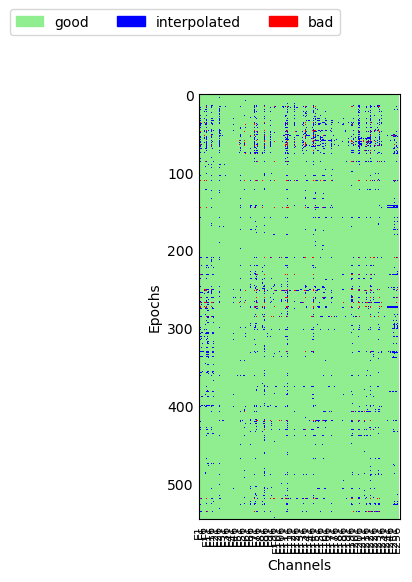

Not setting metadata
546 matching events found
No baseline correction applied
0 projection items activated


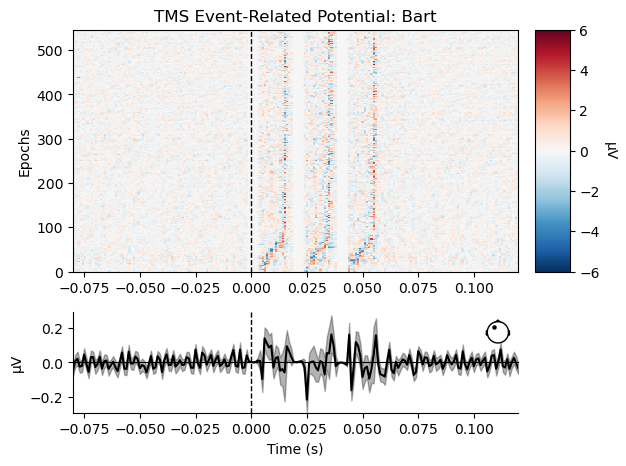

Not setting metadata
546 matching events found
No baseline correction applied
0 projection items activated


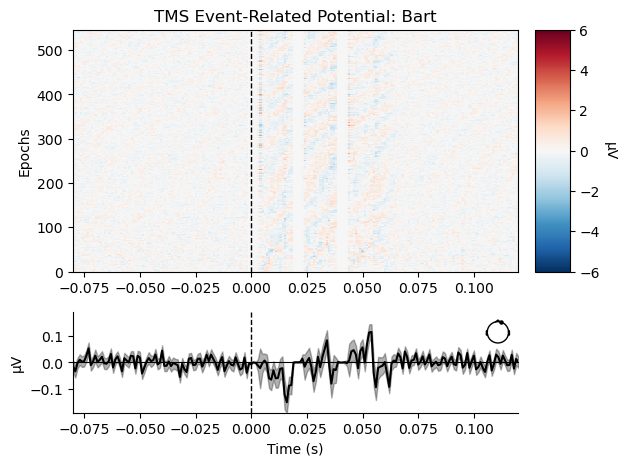

Not setting metadata
546 matching events found
No baseline correction applied
0 projection items activated


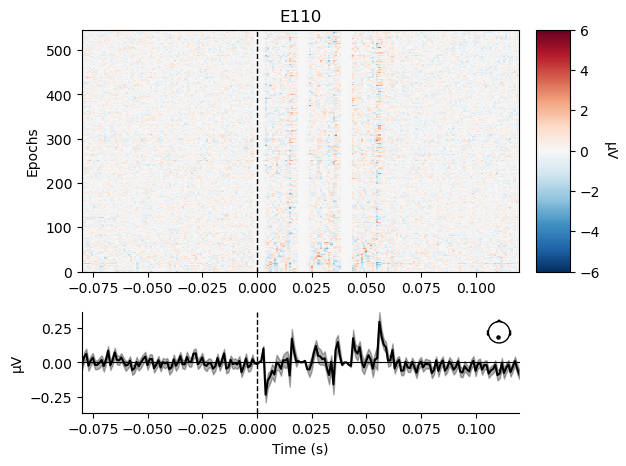

In [43]:
# Plot and save rejected segments log
print(f'Epochs {epochs_autoreject._data.shape}')
print(ar)
print(f'Rejected Segment Plot')
fig = ar.get_reject_log(epochs_autoreject).plot(show=True)
fig.savefig(f'{AR_path}{patient_id}_{day}_rejected_segments.png')

# Plot ERP after tensor decomp + filtering + bad channel and bad segment rejection
# Channel 33
fig = epochs_autoreject.plot_image(picks=['E30'], vmin= -6, vmax= 6, title=f'TMS Event-Related Potential: {responder_status}')
fig[0].axes[1].set_ylim([-3, 3])
fig[0]
fig[0].savefig(f'{ERP_path}{patient_id}_{day}_E30_tucker{rank}_{components_to_remove}_autoreject.png')
# Channel 19
fig = epochs_autoreject.plot_image(picks=['E19'], vmin= -6, vmax= 6, title=f'TMS Event-Related Potential: {responder_status}')
fig[0].axes[1].set_ylim([-3, 3])
fig[0]
fig[0].savefig(f'{ERP_path}{patient_id}_{day}_E19_tucker{rank}_{components_to_remove}_autoreject.png')
# Channel 110
fig = epochs_autoreject.plot_image(picks=['E110'], vmin= -6, vmax= 6)
fig[0].axes[1].set_ylim([-3, 3])
fig[0]
fig[0].savefig(f'{ERP_path}{patient_id}_{day}_E110_tucker{rank}_{components_to_remove}_autoreject.png')

For reloading saved clean data if jupyter notebook barfs

In [ ]:
#epochs_autoreject = mne.read_epochs(f'{mne_path}{patient_id}_{day}_autoreject_epo.fif', preload=True)

In [ ]:
#epochs_autoreject.plot(title='Epochs after bad segment rejection')

### High pass filter for slow drifts and Notch filter for 60 Hz noise

In [41]:
notch_freqs = [60,120,180,240,300,360,400,420,460,480]
notch_widths = 8  # There is significant 60 Hz noise in this data, especially at the 240 Hz harmonic
hp_threshold = 0.1
lp_threshold = None

def notch_and_hp(raw, notch_freqs, notch_widths, l_freq, h_freq, filter_type):
    notch_freqs = np.array(notch_freqs)
    notch_widths = notch_widths
    raw_notch = raw.copy().notch_filter(freqs=notch_freqs, notch_widths=notch_widths, verbose='warning')
    raw_filt = raw_notch.filter(l_freq=l_freq, h_freq=h_freq, method=filter_type, verbose='warning')
    return raw_filt
    
raw_filt = notch_and_hp(raw_autoreject, notch_freqs, notch_widths, l_freq=hp_threshold, h_freq=lp_threshold, filter_type='fir')

# Remake epochs after temporal filtering
events = mne.find_events(raw_filt, stim_channel = 'DIN1')
epochs_filt = mne.Epochs(raw_filt, events, tmin=-0.08, tmax=0.12, preload=True)

# Save temporally-filtered epochs and raw to file
print(f'Filtering under {hp_threshold} Hz and at 60 Hz for {day} complete. Saving filtered raw and epochs files to {mne_path}')
raw_filt.save(f'{mne_path}{patient_id}_{day}_tucker{rank}_{components_to_remove}_filt_hp{hp_threshold}_lp{lp_threshold}_raw.fif',overwrite=True)
epochs_filt.save(f'{mne_path}{patient_id}_{day}_tucker{rank}_{components_to_remove}_filt_hp{hp_threshold}_lp{lp_threshold}_epo.fif',overwrite=True)

546 events found
Event IDs: [1]
Not setting metadata
546 matching events found
Setting baseline interval to [-0.08, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 546 events and 201 original time points ...
0 bad epochs dropped
Filtering under 0.1 Hz and at 60 Hz for day1 complete. Saving filtered raw and epochs files to /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/
Overwriting existing file.
Writing /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/bart_day1_tucker200_32_filt_hp0.1_lpNone_raw.fif
Closing /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/bart_day1_tucker200_32_filt_hp0.1_lpNone_raw.fif
[done]
Overwriting existing file.


Saving ERP images for filtered data to /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/ERP/
Not setting metadata
546 matching events found
No baseline correction applied
0 projection items activated


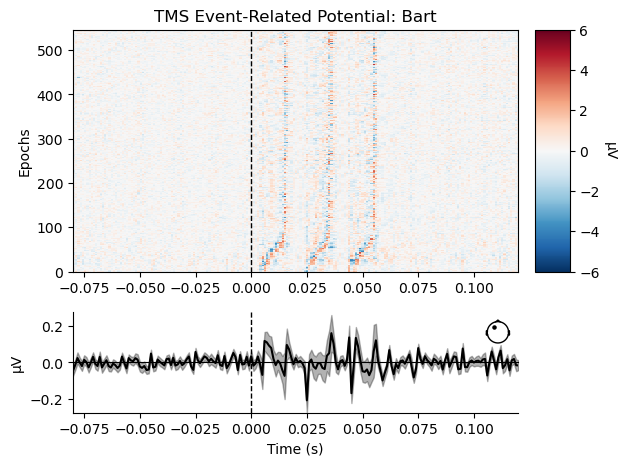

Not setting metadata
546 matching events found
No baseline correction applied
0 projection items activated


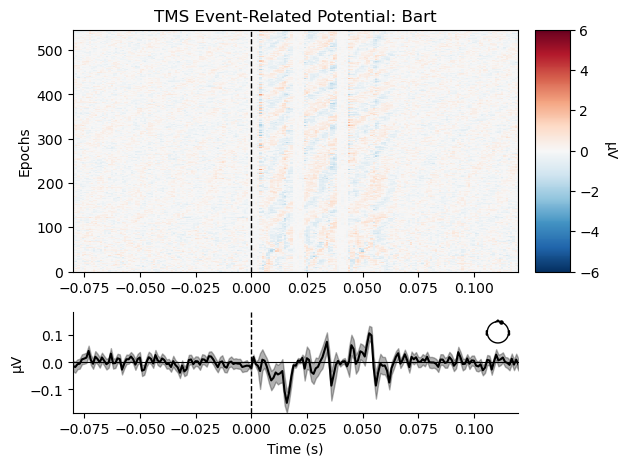

Not setting metadata
546 matching events found
No baseline correction applied
0 projection items activated


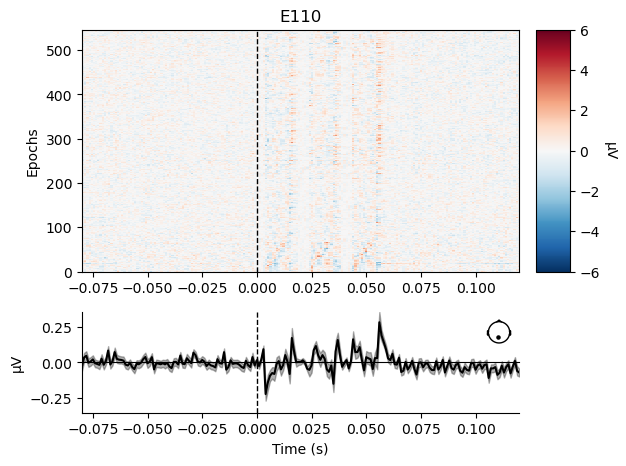

In [42]:
%matplotlib inline
# Plot ERP traces filt
print(f'Saving ERP images for filtered data to {ERP_path}')

# Channel E33
fig = epochs_filt.plot_image(picks=['E30'], vmin= -6, vmax= 6, title=f'TMS Event-Related Potential: {responder_status}')
fig[0].axes[1].set_ylim([-3,3])
fig[0]
fig[0].savefig(f'{ERP_path}{patient_id}_{day}_E30_tucker{rank}_{components_to_remove}_filt_hp{hp_threshold}_lp{lp_threshold}.png')

# Channel E19
fig = epochs_filt.plot_image(picks=['E19'], vmin= -6, vmax= 6, title=f'TMS Event-Related Potential: {responder_status}')
fig[0].axes[1].set_ylim([-3,3])
fig[0]
fig[0].savefig(f'{ERP_path}{patient_id}_{day}_E19_tucker{rank}_{components_to_remove}_filt_hp{hp_threshold}_lp{lp_threshold}.png')

# Channel E110
fig = epochs_filt.plot_image(picks=['E110'], vmin= -6, vmax= 6)
fig[0].axes[1].set_ylim([-3,3])
fig[0]
fig[0].savefig(f'{ERP_path}{patient_id}_{day}_E110_tucker{rank}_{components_to_remove}_filt_hp{hp_threshold}_lp{lp_threshold}.png')

In [ ]:
epochs_filt.plot(title='Epochs after temporal filtering')

In [ ]:
raw_filt.compute_psd().plot()

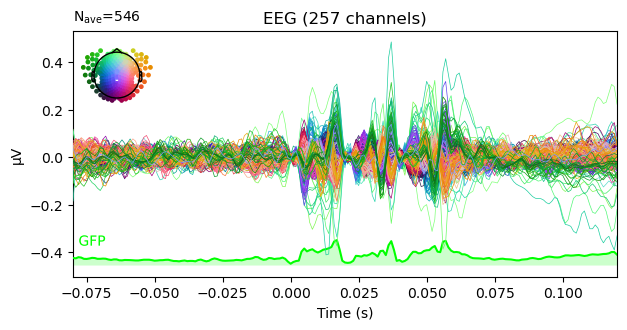

Saving raw TEP image file to: /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/bart/mne/day1/ERP/


In [39]:
#epochs_filt.info['bads'] = ['E39', 'E33', 'E40', 'E32', 'E36']
# Plot TEP again now after cleaning
# Create average evoked
avg_evoked_filt = epochs_filt.copy().average()

# Plot whole brain average evoked activity (microvolts)
fig = avg_evoked_filt.plot(gfp=True)

# Save raw TEP plot
print(f'Saving raw TEP image file to: {ERP_path}')
fig.savefig(f'{ERP_path}/{patient_id}_{day}_tucker{rank}_{components_to_remove}_TEP_filt_hp{hp_threshold}_lp{lp_threshold}.png')

Next: insert cleaned epochs back into raw. May need to do this prior to bad segment rejection and temporal filtering. 